In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/BERT/SA

/content/drive/MyDrive/BERT/SA


In [ ]:
!pip3 install fairseq --quiet
!pip3 install fastbpe --quiet
!pip3 install vncorenlp --quiet
!pip3 install transformers --quiet
!git clone https://github.com/vncorenlp/VnCoreNLP

fatal: destination path 'VnCoreNLP' already exists and is not an empty directory.


In [ ]:
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz
!wget https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
!tar -xzvf PhoBERT_base_fairseq.tar.gz

--2022-09-12 13:57:57--  https://public.vinai.io/PhoBERT_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 52.84.162.36, 52.84.162.17, 52.84.162.15, ...
Connecting to public.vinai.io (public.vinai.io)|52.84.162.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322405979 (307M) [application/x-tar]
Saving to: ‘PhoBERT_base_transformers.tar.gz.1’

PhoBERT_base_transf 100%[===================>] 307.47M  56.7MB/s    in 5.2s    

2022-09-12 13:58:03 (58.8 MB/s) - ‘PhoBERT_base_transformers.tar.gz.1’ saved [322405979/322405979]

PhoBERT_base_transformers/
PhoBERT_base_transformers/config.json
PhoBERT_base_transformers/bpe.codes
PhoBERT_base_transformers/model.bin
PhoBERT_base_transformers/dict.txt
--2022-09-12 13:58:24--  https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
Resolving public.vinai.io (public.vinai.io)... 52.84.162.36, 52.84.162.17, 52.84.162.15, ...
Connecting to public.vinai.io (public.vinai.io)|52.84.162.36|:443... connected.
H

In [ ]:
import pandas as pd

In [ ]:
df_train_final = pd.read_csv('VNCore_train_data_54.csv')
df_test_final = pd.read_csv('VNCore_test_data_54.csv')

In [ ]:
print(len(df_train_final['label'].unique()))

54


In [ ]:
import os

class CFG:
    num_classes = len(df_train_final['label'])
    classes = df_train_final['label'].unique()
    num_epochs = 0
    warmup_epochs = 2
    batch_size = 32
    accumulation_steps = 2
    lr = 3e-5
    ckpt_path = '/content/drive/MyDrive/Model_NLP'
    os.makedirs(ckpt_path, exist_ok=True)

In [ ]:
import numpy as np
from fairseq.data.encoders.fastbpe import fastBPE
from vncorenlp import VnCoreNLP
from fairseq.data import Dictionary
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
seed_everything(2001)

In [ ]:
from fairseq.models.roberta import RobertaModel
phoBERT = RobertaModel.from_pretrained('PhoBERT_base_fairseq', checkpoint_file='model.pt')
phoBERT.eval()
vocab = Dictionary()
vocab.add_from_file("./PhoBERT_base_transformers/dict.txt")

In [ ]:
from fairseq.data.encoders.fastbpe import fastBPE

class BPE():
    bpe_codes = 'PhoBERT_base_fairseq/bpe.codes'
args = BPE()
phoBERT.bpe = fastBPE(args)
tokens = phoBERT.encode('Đại học BKHN')
print(tokens)

tensor([   0, 3449,  222,  924, 8777, 2285,    2])


In [ ]:
max_sequence_length = 256

def convert_lines(lines, vocab, bpe):

    outputs = np.zeros((len(lines), max_sequence_length), dtype=np.int32)
    cls_id = 0
    eos_id = 2
    pad_id = 1

    for idx, row in tqdm(enumerate(lines), total=len(lines)): 

        subwords = bpe.encode('<s> '+ row +' </s>')
        input_ids = vocab.encode_line(subwords, append_eos=False, add_if_not_exist=False).long().tolist()

        if len(input_ids) > max_sequence_length: 
            input_ids = input_ids[:max_sequence_length] 
            input_ids[-1] = eos_id
        else:
            input_ids = input_ids + [pad_id, ]*(max_sequence_length - len(input_ids))
    
        outputs[idx,:] = np.array(input_ids)
    return outputs

In [ ]:
def encode_comment(vocab, bpe, df):
    content = df['content'].tolist()
    labels = df['label'].tolist()
    arr_data = convert_lines(content, vocab, bpe)
    return arr_data, labels

In [ ]:
class NewspaperDataset(Dataset):
    def __init__(self, content, labels):
        super().__init__()
        self.content = content
        self.labels = labels
    def __len__(self):
        return len(self.content)
    def __getitem__(self, index):
        content = self.content[index]
        label = self.labels[index]
        content = torch.tensor(content, dtype=torch.int64)
        label = torch.tensor(int(label),dtype=torch.int64)
        return content, label

In [ ]:
from transformers import RobertaModel
from transformers import BertPreTrainedModel, RobertaConfig

class NewspaperModel(BertPreTrainedModel):
    config_class = RobertaConfig
    base_model_prefix = "roberta"
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)
        self.qa_outputs = nn.Linear(4*config.hidden_size, self.num_labels)

        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                start_positions=None, end_positions=None):

        outputs = self.roberta(input_ids,
                            attention_mask=attention_mask,
                            position_ids=position_ids,
                            head_mask=head_mask)
        cls_output = torch.cat((outputs[2][-1][:,0, ...],outputs[2][-2][:,0, ...], outputs[2][-3][:,0, ...], outputs[2][-4][:,0, ...]),-1)
        logits = self.qa_outputs(cls_output)
        return logits

In [ ]:
config_path = 'PhoBERT_base_transformers/config.json'
pretrained_path = 'PhoBERT_base_transformers/model.bin'
config = RobertaConfig.from_pretrained(
    config_path,
    output_hidden_states=True,
    num_labels=54,
)
model_bert = NewspaperModel.from_pretrained(pretrained_path, config=config)
# model_bert.cuda()

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at PhoBERT_base_transformers/model.bin were not used when initializing NewspaperModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing NewspaperModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewspaperModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of NewspaperModel were not initialized from the model checkpoint at PhoBERT_bas

In [ ]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-rdiuupvh
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-rdiuupvh
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.utils.data
from torch.optim.sgd import SGD
from warmup_scheduler import GradualWarmupScheduler
import torch.nn.functional as F
from loguru import logger
import warnings
warnings.filterwarnings('ignore')

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_score(y_pred, y_true):
    return accuracy_score(y_pred, y_true)

optimizer = Adam(model_bert.parameters(), lr=CFG.lr)
scheduler = CosineAnnealingLR(optimizer, T_max=CFG.num_epochs + 5)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=CFG.warmup_epochs, after_scheduler=scheduler)

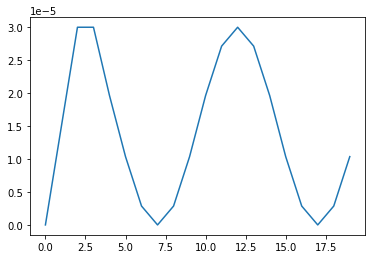

In [ ]:
v = torch.zeros(10)
a = []
b = []
for epoch in range(0, 20):
    scheduler_warmup.step(epoch)
    a.append(epoch)
    b.append(optimizer.param_groups[0]["lr"])
#     print(epoch, optim.param_groups[0]["lr"])
plt.plot(a[:], b[:])

In [ ]:
def train_fn(train_loader, model, optimizer, device):
    losses = AverageMeter()
    optimizer.zero_grad()
    model_bert.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Train ')
    for i,(x_batch, y_batch) in pbar:
        batch_size = x_batch.shape[0]
        model_bert.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        y_pred = model_bert(x_batch, attention_mask=(x_batch>0).cuda())
        loss =  nn.CrossEntropyLoss()(y_pred.cuda(), y_batch.cuda())
        losses.update(loss.item(), batch_size)
        loss.backward()
        if i % CFG.accumulation_steps == 0 or i == len(train_loader) - 1:
            optimizer.step()
            optimizer.zero_grad()
        
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{losses.avg:0.4f}',
                        lr=f'{current_lr:0.8f}',
                        gpu_mem=f'{mem:0.2f} GB')
    return losses.avg

def valid_fn(valid_loader, model, optimizer, device):
    val_preds = None
    avg_loss = 0.0
    for i,(x_batch, y_batch) in tqdm(enumerate(valid_loader)):
        with torch.no_grad():
            y_pred = model_bert(x_batch.cuda(), attention_mask=(x_batch>0).cuda())
        loss =  nn.CrossEntropyLoss()(y_pred.cuda(), y_batch.cuda())
        loss = loss.mean()
        avg_loss += loss.item() / len(valid_loader)
        y_pred = y_pred.softmax(1)
        val_preds = torch.cat((val_preds, y_pred),0) if val_preds is not None else y_pred
        
    val_preds = val_preds.detach().cpu().numpy()
    val_preds = np.argmax(val_preds, axis=1)
    return val_preds, avg_loss


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df_train_final['label'] = encoder.fit_transform(df_train_final['label'])
df_test_final['label'] = encoder.fit_transform(df_test_final['label'])

In [ ]:
model_bert = model_bert.cuda()
if torch.cuda.device_count():
    logger.info(f"Training using {torch.cuda.device_count()} gpus")
    tsfm = model_bert.roberta
else:
    tsfm = model_bert.roberta
best_score = 0
train_df = df_train_final
valid_df = df_test_final
label = valid_df.label.values
train_cms, train_labels = encode_comment(vocab, phoBERT.bpe, train_df)
valid_cms, valid_labels = encode_comment(vocab, phoBERT.bpe, valid_df)
# train_dataset = NewspaperDataset(train_cms, train_labels)
# valid_dataset = NewspaperDataset(valid_cms, valid_labels)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)
# tq = tqdm(range(CFG.num_epochs + 1))
# best_th = 0
# for epoch in tq:
#     scheduler_warmup.step(epoch)
#     avg_loss = 0.
#     avg_accuracy = 0.
#     print(optimizer.param_groups[0]['lr'])
#     train_loss = train_fn(train_loader, model_bert, optimizer, device)
#     val_preds, val_loss = valid_fn(valid_loader, model_bert, optimizer, device)
    
#     acc_score = get_score(val_preds, label)
#     logger.info(f"\nAccuracy = {acc_score}")
#     if acc_score >= best_score:
#         torch.save(model_bert.state_dict(),os.path.join(CFG.ckpt_path, f"model_{fold}.pth"))
#         best_score = acc_score

2022-09-12 14:00:21.187 | INFO     | __main__:<module>:3 - Training using 1 gpus
100%|██████████| 30713/30713 [01:56<00:00, 262.94it/s]


In [ ]:
train_dataset = NewspaperDataset(train_cms, df_train_final['label'])
valid_dataset = NewspaperDataset(valid_cms, df_test_final['label'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)

In [ ]:
print(train_loader)

In [ ]:
train_dataset = NewspaperDataset(train_cms, df_train_final['label'])
valid_dataset = NewspaperDataset(valid_cms, df_test_final['label'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)
tq = tqdm(range(CFG.num_epochs + 1))
best_th = 0
for epoch in tq:
    scheduler_warmup.step(epoch)
    avg_loss = 0.
    avg_accuracy = 0.
    print(optimizer.param_groups[0]['lr'])
    train_loss = train_fn(train_loader, model_bert, optimizer, device)
    val_preds, val_loss = valid_fn(valid_loader, model_bert, optimizer, device)
    
    acc_score = get_score(val_preds, label)
    logger.info(f"\nAccuracy = {acc_score}")
    if acc_score >= best_score:
        torch.save(model_bert.state_dict(),os.path.join(CFG.ckpt_path, f"model_BERT_13.pth"))
        best_score = acc_score

  0%|          | 0/1 [00:00<?, ?it/s]

1.963525491562421e-05


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Train : 100%|██████████| 3843/3843 [1:30:36<00:00,  1.41s/it, gpu_mem=10.38 GB, lr=0.00001964, train_loss=0.5159]

0it [00:00, ?it/s]
1it [00:00,  1.92it/s]
2it [00:01,  1.89it/s]
3it [00:01,  1.93it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.93it/s]
6it [00:03,  1.92it/s]
7it [00:03,  1.93it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.93it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.93it/s]
12it [00:06,  1.93it/s]
13it [00:06,  1.94it/s]
14it [00:07,  1.93it/s]
15it [00:07,  1.94it/s]
16it [00:08,  1.93it/s]
17it [00:08,  1.93it/s]
18it [00:09,  1.93it/s]
19it [00:09,  1.93it/s]
20it [00:10,  1.92it/s]
21it [00:10,  1.93it/s]
22it [00:11,  1.93it/s]
23it [00:11,  1.93it/s]
24it [00:12,  1.93it/s]
25it [00:12,  1.92it/s]
26it [00:13,  1.93it/s]
27it [00:14,  1.92it/s]
28it [00:14,  1.93it/s]
29it [00:15,  1.92it/s]
30it [00:15,  1.93it/s]
31it [00:16,  1.92it/s]
32it [00:16,  1.92it/s]
33it [00:17,  1.91it/s]
34it [00:17,  1.91it/s]
35

In [ ]:
model = NewspaperModel.from_pretrained(pretrained_path, config=config)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model_NLP/model_BERT_13.pth'))
model.eval()

Some weights of the model checkpoint at PhoBERT_base_transformers/model.bin were not used when initializing NewspaperModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing NewspaperModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewspaperModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of NewspaperModel were not initialized from the model checkpoint at PhoBERT_base_transformers/model.bin and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task 

NewspaperModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=0)
      (position_embeddings): Embedding(258, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [ ]:
val_preds = valid_fn(valid_loader, model, optimizer, device)[0]

960it [08:12,  1.95it/s]


In [ ]:
acc_score = get_score(val_preds, label)
print(acc_score)

In [ ]:
for i in val_preds:
  print(i)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
49
15
15
7
15
15
15
15
15
15
15
15
15
52
15
15
15
15
15
15
15
53
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
49
15
15
15
15
15
15
15
15
15
15
15
15
15
15
37
19
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
19
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
9
37
19
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
25
37
37
37
37
37
37
37
37
37
37
37
37
37
37
19
37
37
37
37
37
37
37
37
37
37
37
37
37


In [ ]:
print(len(val_preds))

30713


In [ ]:
print(len(label))

30713


In [ ]:
for i in label:
  print(i)

Streaming output truncated to the last 5000 lines.
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
3

In [ ]:
from sklearn.metrics import classification_report
y_pred = encoder.inverse_transform(val_preds)
y_test = encoder.inverse_transform(label)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

           am-thuc       0.93      0.92      0.92       443
      bat-dong-san       0.97      0.96      0.96       699
   bong-da-quoc-te       0.99      1.00      1.00       626
  bong-da-viet-nam       0.99      0.99      0.99       700
           bong-ro       0.99      0.99      0.99       700
         chinh-tri       0.83      0.93      0.88       667
       chung-khoan       0.91      0.95      0.93       700
   cntt-vien-thong       0.88      0.76      0.82       689
          diem-den       0.89      0.76      0.82       389
          diem-tin       0.77      0.65      0.70       321
        dien-thoai       0.87      0.93      0.90       644
dinh-duong-lam-dep       0.78      0.90      0.83       432
      doanh-nghiep       0.81      0.86      0.83       700
            du-hoc       0.97      0.98      0.97       700
             ebank       0.93      0.92      0.93       699
              game       1.00      0.98